# Latent Dirichlet Allocation

The purpose of applying the LDA method is to obtain the distribution of words that make up a topic and documents with a particular topic. The first stage in LDA modeling is to initialize the parameters. These parameters can be the number of documents, the number of words in the document, the number of topics, the number of iterations, and the LDA coefficient. The next stage is to mark a word with a predetermined topic by applying a semi-random distribution based on the Dirichlet distribution method. Next is the iteration stage. In this stage, there are parameters that can determine the distribution of the number of topics and the distribution of words from topics in a document.

## Dependencies

In [1]:
!pip install google-cloud-bigquery
!pip install PySastrawi
!pip install nltk
!pip install pyLDAvis

In [2]:
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from string import punctuation
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from gensim.models.coherencemodel import CoherenceModel
import re
import pyLDAvis.gensim_models
import pickle

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Load Data

In [3]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'future-data-track-1-sapporo.json'

In [4]:
# Imports the Google Cloud client library
from google.cloud import bigquery

In [5]:
# Instantiates a client for Bigquery Service
bigquery_client = bigquery.Client(project='future-data-track-1')

In [6]:
# Query for BigQuery
QUERY = """
SELECT
  *
FROM
  `future-data-track-1.sapporo_mart.topic_modelling`
"""

In [7]:
# Run the query and get data from BigQuery
query_job = bigquery_client.query(QUERY) # API request

In [8]:
# Turn the data into pandas DataFrame
df = query_job.to_dataframe()

In [9]:
# Show the result
df

,review,rating
0,IKLAN NYA GANGGU AS*,1
1,Pihak lazada tolong di mengerti masa saya pesa...,1
2,"Iklan trossssssss, ganggu aja",1
3,Lazada Ruwet anjir. Mau menggunakan metode pem...,1
4,Dih jangan dwon ni aplikasi tempat para penipu...,1
...,...,...
1695878,Sangat membantu,5
1695879,Sangat membantu,5
1695880,Sangat membantu,5
1695881,Sangat membantu,5


## Preprocess

### Initial Stopwords

In [10]:
# Extending Sastrawi StopWords

class ExtendStopWordRemoverFactory(StopWordRemoverFactory):
  def get_stop_words(self):
    new_sw = [
              "ud","udah","sdh","sudah","kalau","klo","sy","aing","saia","gue"
    ,"awak","aq","gua","gw","ak","aku","saya","banget","blibli","tokopedia"
    ,"shopee","bukalapak","lazada","jdid","zalora","elevenia","sudah","bhinneka"
    ,"gk","yg","ga","gak","nggak","saja","aja","aj","ada","adalah","adanya"
    ,"adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri"
    ,"akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar"
    ,"antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah"
    ,"artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal"
    ,"awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun"
    ,"bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan"
    ,"balik","banyak","bapak","baru","bawah","beberapa","begini","beginian"
    ,"beginikah","beginilah","begitu","begitukah","begitulah","begitupun"
    ,"bekerja","belakang","belakangan","belum","belumlah","benar","benarkah"
    ,"benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa"
    ,"berapakah","berapalah","berapapun","berarti","berawal","berbagai"
    ,"berdatangan","beri","berikan","berikut","berikutnya","berjumlah"
    ,"berkali-kali","berkata","berkehendak","berkeinginan","berkenaan"
    ,"berlainan","berlalu","berlangsung","berlebihan","bermacam"
    ,"bermacam-macam","bermaksud","bermula","bersama","bersama-sama","bersiap"
    ,"bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut"
    ,"bertutur","berujar","berupa","besar","betul","betulkah","biasa"
    ,"biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah"
    ,"buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara"
    ,"caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan"
    ,"dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah"
    ,"dengan","depan","di","dia","diakhiri","diakhirinya","dialah","diantara"
    ,"diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya"
    ,"didapat","didatangkan","digunakan","diibaratkan","diibaratkannya"
    ,"diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya"
    ,"dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui"
    ,"diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud"
    ,"dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai"
    ,"dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini"
    ,"dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan"
    ,"diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan"
    ,"dipunyai","diri","dirinya","disampaikan","disebut","disebutkan"
    ,"disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya"
    ,"ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki"
    ,"ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya"
    ,"diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat"
    ,"enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir"
    ,"hanya","hanyalah","hari","harus","haruslah","harusnya","hendak"
    ,"hendaklah","hendaknya","hingga","ia","ialah","ibarat","ibaratkan"
    ,"ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah"
    ,"inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi"
    ,"jadilah","jadinya","jangan","jangankan","janganlah","jauh","jawab"
    ,"jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika"
    ,"jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah"
    ,"kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan"
    ,"kapankah","kapanpun","karena","karenanya","kasus","kata","katakan"
    ,"katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua"
    ,"keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima"
    ,"keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa"
    ,"kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya"
    ,"keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira"
    ,"kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain"
    ,"lainnya","lalu","lama","lamanya","lanjut","lanjutnya","lebih","lewat"
    ,"lima","luar","macam","maka","makanya","makin","malah","malahan","mampu"
    ,"mampukah","mana","manakala","manalagi","masa","masalah","masalahnya"
    ,"masih","masihkah","masing","masing-masing","mau","maupun","melainkan"
    ,"melakukan","melalui","melihat","melihatnya","memang","memastikan"
    ,"memberi","memberikan","membuat","memerlukan","memihak","meminta"
    ,"memintakan","memisalkan","memperbuat","mempergunakan","memperkirakan"
    ,"memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan"
    ,"mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan"
    ,"menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan"
    ,"mendapat","mendapatkan","mendatang","mendatangi","mendatangkan"
    ,"menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai"
    ,"mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan"
    ,"mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira"
    ,"mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab"
    ,"menjelaskan","menuju","menunjuk","menunjuki","menunjukkan","menunjuknya"
    ,"menurut","menuturkan","menyampaikan","menyangkut","menyatakan"
    ,"menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah"
    ,"merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip"
    ,"misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin"
    ,"mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya"
    ,"oleh","olehnya","pada","padahal","padanya","pak","paling","panjang"
    ,"pantas","para","pasti","pastilah","penting","pentingnya","per","percuma"
    ,"perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama"
    ,"pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya"
    ,"rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah"
    ,"saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan"
    ,"sana","sangat","sangatlah","satu","saya","sayalah","se","sebab","sebabnya"
    ,"sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya"
    ,"sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum"
    ,"sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya"
    ,"sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang"
    ,"sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala"
    ,"segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh"
    ,"sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali"
    ,"sekalian","sekaligus","sekalipun","sekarang","sekarang","sekecil"
    ,"seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya"
    ,"sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya"
    ,"selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin"
    ,"semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya"
    ,"sementara","semisal","semisalnya","sempat","semua","semuanya","semula"
    ,"sendiri","sendirian","sendirinya","seolah","seolah-olah","seorang"
    ,"sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti"
    ,"sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat"
    ,"sesama","sesampai","sesegera","sesekali","seseorang","sesuatu"
    ,"sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah"
    ,"seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya"
    ,"setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini"
    ,"sinilah","soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya"
    ,"tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak"
    ,"tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya"
    ,"tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu"
    ,"tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu"
    ,"terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat"
    ,"terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih"
    ,"terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah"
    ,"tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba"
    ,"tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk"
    ,"turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum"
    ,"umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai"
    ,"waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang"
    ,"anjing","anjiang","anjir","anjay","anying","asu","asoe","babi","bajingan"
    ,"banci","bangsat","bego","bengak","berak","bokong","bodoh","bongak","edan"
    ,"fak","fuck","fakboi","bitch","fap","gigolo","goblok","gila","gilo"
    ,"jablay","jalang","jancuk","jancok","kampret","kafir","kontol","kentot"
    ,"dancok","kunyuk","kufar","kimak","homo","maho","memek","monyet","ngentot"
    ,"pantat","pantak","pantek","pecun","pelakor","ngehe","pelacur","perek"
    ,"peler","pepek","pukimak","setan","syaithon","saiton","sial","sialan"
    ,"sinting","sintiang","silit","sontoloyo","tai","telek","tolol","lonte"
    ,"entut","gimana","widihh","nya","gabisa","nambah","kontoll"
    ,"ih",
    "sih","selesai","banget","si","knapa","bngt","kamu","an","tanggal"
    ,"dizalora","in","an","ini","emang","sngt","many","to","thank","you","ko"
    ,"tumben","lho","segitu","kalau","doang","ayo","doank","rbuan","woi"
    ,"parahhhh","trus","woy","emg","gausah","udh","gadak","huhh","akh","nanti"
    ,"belum","cuiiihhh","bangt","selamat","begitu","bhineka","situ","loh","deh"
    ,"mah","yaa","tapi","the","karena","padabal","ttep","sopi","ealah","mas"
    ,"kampreeeeet","busetttt","tahi","ah","sich","tokped","lzd","gada","gatau"
    ,"udh","ttep","ehhh","bosss","wkekwk","bajing","laknat","asuuu","ku","woiii"
    ,"gueeee","njerr","waduhhhh","ma","dunk","dunk","untuk","dll","brupa"
    ,"sangatx","niih","bos","eh","smua","gni","bye","ajah","gilee","luu","ndro"
    ,"dg","kga","min","sm","haisshhh","piye","iki","skali","hehehe","ms","juga"
    ,"fff","mamam","inibsangat","andri","yopiyanto","broo","donk","tes","si"
    ,"ter","dech","wow","oh","toped","dahhhh","grab","ijo","oren","ovo","gopay"
    ,"kredivo","sok","david","gaes","dr","ovonya","bbrp","gmna","bbrpa","and"
    ,"uah","uhahhhhhh","topeeed","ngak","kamu","anj","nge","lah","linkaja"
    ,"gosend","sicepat","jne","yah","goto","gofood","goride","prakerja"
    ,"haduhhhh","pediya","kakak","hhe","bro","bismillah","fuulll","goof"
    ,"assalamualaikum","atsu","pea","you","agan","semenjak","gojek","lagiii"
    ,"lagi","bts","kkzara","cog","aaaaa","sich","cih","ciyy","padahal","ad"
    ,"adlh","ahaha","aj","ak","akika","akkoh","akuwh","alow","anjrit","ap2"
    ,"apasih","aps","aq","aqueh","q","asem","ato","awak","bakalan","bangedh"
    ,"bcanda","beud","bg","bgmn","bgt","bkl","bknnya","blum","boljug","boyeh"
    ,"bs","bt","btw","bwt","byk","can","thanks","d","dah","dapet","de","dek"
    ,"deyh","dgn","disono","dkk","dlu","dngn","dongs","dpt","dri","drmn","drtd"
    ,"dst","duh","egp","eke","ane","ente","elu","emangnya","emng","endak"
    ,"enggak","gaada","gag","gaje","gpp","gan","gbs","geje","ghiy","gimana"
    ,"githu","gj","gn","gt","gpny","gr","gtau","guoblok","ha","haha","hallow"
    ,"hehe","helo","he","halo","hey","hai","hny","hrus","imho","iye","ja"
    ,"jadiin","jdi","jga","jir","k","kagak","kalo","kamuwh","karna","katrok"
    ,"kayanya","kdu","kepengen","kepingin","kl","klianz","klw","km","knp","kpn"
    ,"kt","kyk","leh","lgi","lgsg","liat","low","lum","maneh","mao","mw","n"
    ,"napa","nda","ne","ngapah","ngga","ngmng","nie","nih","niyh","np","ogah"
    ,"pd","pi","pisan","qmu","ruz","saia","samsek","siech","sj","spt","sgt"
    ,"shg","scr","sbh","sbnrny","sdgkn","td","thankz","tks","ttg","tuch","tuh"
    ,"u","urang","yawdah","yasudah","adlah","ajj","akko","akyu","ama","aqu"
    ,"atuh","ayok","bet","beut","bgd","brur","bapak","ibu","bokap","nyokap"
    ,"cama","ceu","teh","coz","cpa","guys","kaka","kamuh","kamyu","kau","khan"
    ,"kk","klian","koq","ky","krn","kykny","lu","lw","maaciw","makasih","mba"
    ,"mas","nyok","qmo","qt","spy","sy","thanks","thx","tp","tq","trims","mz"
    ,"alfamart","cm"
    ,"buruk","lambat","jelek","bagus","ok","oke","kecewa","mantap","manfaat"
    ,"gblk","ni","keren","bagus","ajg","iya","tidak","muas","puas","goblog"
    ,"tdk","dancuk","huff","lumayan","mayan","y","eek","belum","blm","nyesel"
    ,"bahagia","senang","seneng","mantul","good","top","suka","not","bad"
    ,"kak","okey","gitu","coba","sip","nice","job","thanks","terima kasih"
    ,"moga","lasada","jd","id","parah","for","sumpah","best","bli","payah"
    ,"blibi","blipay","gg","love","amazing","mantab","terimakasih","cakep"
    ,"very","bgs","jos","is","euy","gandos","of","waw","biar"
    ]
    new_sw.extend(super().get_stop_words())
    return list(set(new_sw))

### Initial Stemming

using sastrawi

In [11]:
# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

### Initial Formalization

In [12]:
formalization_indo = {
    "@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "ahaha": "haha", "aj": "saja", "ajep-ajep": "disko", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa", "apasih": "apa", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "palsu", "ato": "atau", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bangedh": "banget", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "beli", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "benar", "bodor": "lucu", "bokap": "ayah", "bokis": "bohong", "boljug": "boleh", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong", "bubbu": "tidur", "bubu": "tidur", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "ce": "cewek", "cekal": "cegah", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmpur": "campur", "cong": "banci", "cowwyy": "maaf", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cups": "culun", "curanmor": "pencurian", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "hancur", "dimaafin": "maaf", "dimintak": "minta", "disono": "sana", "dket": "dekat", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dtg": "datang", "duren": "durian", "ed": "edisi", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fyi": "informasi", "gag": "tidak", "gan": "juragan", "gawe": "kerja", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "githu": "gitu", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "gretongan": "gratis", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hr": "hari", "hrus": "harus", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "benci", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamuwh": "kamu", "karna": "karena", "katrok": "kampungan", "kayanya": "seperti", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kekeuh": "bersikeras", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "ketrima": "terima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lemot", "louph": "cinta", "low": "kalau", "lp": "lupa", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "maho": "homo", "maksain": "maksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat", "mgu": "minggu", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mulu": "melulu", "mumpung": "selagi", "musti": "mesti", "muupz": "maaf", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "ngaku": "mengaku", "ngambil": "mengambil", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "beri", "ngebandel": "bandel", "ngegosip": "gosip", "ngeklaim": "klaim", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "rampok", "ngga": "tidak", "ngibul": "bohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "cari", "ngurus": "urus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "ntar": "nanti", "ntn": "nonton", "numpuk": "tumpuk", "nutupin": "tutup", "nyari": "cari", "nyekar": "menyekar", "nyicil": "cicil", "nyoblos": "coblos", "nyokap": "ibu", "ol": "online", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pd": "pada", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pisan": "sangat", "pk": "pakai", "plg": "paling", "pmrnth": "pemerintah", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "re": "balas", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruz": "terus", "saia": "saya", "sampe": "sampai", "sapose": "siapa", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sempet": "sempat", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "siramin": "siram", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri",  "songong": "sombong", "sory": "maaf", "sotoy": "tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "telat": "terlambat", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thn": "tahun", "tilang": "bukti pelanggaran", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "w/": "dengan", "wat": "buat", "wkt": "waktu", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yg": "yang", "yo": "iya", "yup": "iya", "7an": "tujuan", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "akko": "aku", "akku": "aku", "akyu": "aku", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "segera", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bales": "balas", "bangkotan": "tua", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "bet": "banget", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bpk": "bapak", "brngkt": "berangkat", "brp": "berapa", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cape": "capek", "caur": "jelek", "cemplungin": "masuk", "ceper": "pendek", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gretong": "gratis", "gt": "begitu", "gue": "saya", "haghaghag": "tertawa", "hakhak": "tertawa", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "huft": "mengeluh", "humas": "hubungan masyarakat", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jwb": "jawab", "ka": "kakak", "kacian": "kasihan", "kaga": "tidak", "kaka": "kakak", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kek": "seperti", "keknya": "seperti", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "penasaran", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "bersikeras", "khan": "kan", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lbur": "libur", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maen": "main", "mak": "ibu", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "mksd": "maksud", "mls": "malas", "mnt": "minta",  "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "muahal": "mahal", "mumet": "pusing", "muna": "munafik", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "naq": "anak", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngantri": "antri", "ngaruh": "pengaruh", "ngawur": "sembarangan", "ngeceng": "kumpul", "ngeh": "sadar", "ngekos": "kos", "ngelamar": "lamar", "ngeliat": "lihat", "ngemeng": "bicara", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "bicara", "ngumpul": "kumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "cari", "nyiapin": "siap", "nyiram": "siram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "sni": "sini", "sorry": "maaf", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "tengok": "jenguk", "terbitin": "terbit", "tgl": "tanggal", "thd": "terhadap", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "tp": "tapi", "trgntg": "tergantung", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "apk": "aplikasi", "dg" : "dengan", "blanja": "belanja", "sukaa": "suka", "cpt": "cepat", "bwrtransaksi": "transaksi", "realpict": "asli", "moga": "semoga", "muas": "puas", "ori": "asli", "ongkirnya": "ongkir", "turunin": "turun", "orii": "asli", "original": "asli", "hargax": "harga", "mehong": "mahal", "kainx": "kain", "rb": "ribu", "shopping": "belanja", "made": "buat", "easier": "mudah", "ways": "cara", "pay": "bayar", "applikasi": "aplikasi", "kwalitas": "kualitas", "good": "bagus", "ngechat": "chat", "ngobrol": "bicara", "ngertiin": "mengerti", "protol": "lepas", "balikin": "balik", "trx": "transaksi", "nyebelin": "sebal", "trf": "transfer", "ngebantuin": "bantu", "org": "orang", "peribet": "ribet", "fedback": "feedback", "koment": "komentar", "takuuut": "takut", "ketipuuuuh": "tipu", "register": "daftar", "hp": "handphone", "org": "orang", "instal": "install", "skarng": "sekarang", "true": "benar", "story": "cerita", "payment": "bayar", "confirm": "konfirmasi", "batalin": "batal", "ig": "instagram", "pelyanan": "layanan", "after": "setelah", "nunggu": "tunggu", "blom": "belum", "reffund": "refund", "jeleeeekkk": "jelek", "make": "pakai", "nyoba": "coba", "pantesan": "pantas", "slow": "lambat", "skrg": "sekarang", "dibalikin": "balik", "transver": "transfer", "pantes": "pantas", "staffnya": "staff", "divalidasi": "validasi", "smpe": "sampai", "pelayananya": "layanan", "komennya": "komentar", "komplin": "komplain", "complaint": "komplain", "hpus": "hapus", "muaaahal": "mahal", "masukkk": "masuk", "tlg": "tolong", "wa": "whatsapp", "luama": "lama", "stokmya": "stok", "ready": "siap", "setrlah": "setelah", "sprt": "seperti", "cs": "customer service", "direspon": "respon","prcuma": "percuma", "bkin": "bikin", "app": "aplikasi", "hape": "handphone", "karti": "kartu",  "apps": "aplikasi", "responnya": "respon", "mahalllll": "mahal", "balesan": "balas", "paswordnya": "password", "masul": "masuk", "ksong": "kosong", "nyarinya": "cari", "kluarnya": "keluar", "system": "sistem", "systemnya": "sistem", "chatt": "chat", "kridit": "kredit", "pelayananya": "layanan", "kwalitasnya": "kualitas","mantap": "bagus", "produck": "produk", "baharu": "baru", "slalu": "selalu", "dwnld": "unduh", "download": "unduh", "sndri":  "sendiri", "batalin": "batal", "mbingungin": "bingung", "vocer": "voucher", "boong”": "bohong", "apus": "hapus", "sori": "maaf", "tf": "transfer", "apknya": "aplikasi", "diem": "diam", "dtang": "datang", "bukak": "buka", "boong": "bohong", "setiyap": "setiap", "sukak": "suka", "ngincer": "incar", "store": "toko", "fiturnya": "fitur", "apkx": "aplikasi", "voucherx": "voucher", "hub": "hubungi", "payaaaaaaaahh": "payah", "apl": "aplikasi", "mamam": "makan", "luama": "lama"
}

In [13]:
formalization_indo

{'7an': 'tujuan',
 '@': 'di',
 'abis': 'habis',
 'ad': 'ada',
 'adlah': 'adalah',
 'adlh': 'adalah',
 'adoh': 'aduh',
 'after': 'setelah',
 'aha': 'tertawa',
 'ahaha': 'haha',
 'ahokncc': 'ahok',
 'aing': 'saya',
 'aj': 'saja',
 'aja': 'saja',
 'ajep-ajep': 'disko',
 'ajj': 'saja',
 'ak': 'saya',
 'akhirx': 'akhirnya',
 'akika': 'aku',
 'akko': 'aku',
 'akkoh': 'aku',
 'akku': 'aku',
 'akuwh': 'aku',
 'akyu': 'aku',
 'alay': 'norak',
 'alow': 'halo',
 'ama': 'sama',
 'ambilin': 'ambilkan',
 'ambl': 'ambil',
 'analisise': 'analisis',
 'ancur': 'hancur',
 'anjir': 'anjing',
 'anjrit': 'anjing',
 'ank': 'anak',
 'anter': 'antar',
 'ap': 'apa',
 'ap2': 'apa',
 'apaan': 'apa',
 'apasih': 'apa',
 'ape': 'apa',
 'apes': 'sial',
 'apk': 'aplikasi',
 'apknya': 'aplikasi',
 'apkx': 'aplikasi',
 'apl': 'aplikasi',
 'aplot': 'unggah',
 'app': 'aplikasi',
 'applikasi': 'aplikasi',
 'apps': 'aplikasi',
 'aps': 'apa',
 'apus': 'hapus',
 'apva': 'apa',
 'aq': 'saya',
 'aqu': 'aku',
 'aquwh': 'aku',
 '

In [15]:
random_state = 0

### Initial Token

In [16]:
# list for tokenized documents in loop
texts = []

In [17]:
tokenizer = RegexpTokenizer(r'\w+')

### Preprocess

This process include casefolding, remove special character, multiple whitespace, stopword, and stemming

In [18]:
def preprocess(value, sw_remover):
  value = value.lower()
  value = re.sub(r'[^a-zA-Z]', ' ', value)
  value = re.sub(r'\s\s+', ' ', value)
  #value = stemmer.stem(value)
  value = sw_remover.remove(value)
  return value

In [19]:
df.dropna(subset = ["review"], inplace=True)

In [20]:
sw_remover = ExtendStopWordRemoverFactory().create_stop_word_remover()
# df['review'] = df['review'].fillna("",inplace=True)
processed_values = df['review'].apply(lambda x: preprocess(x, sw_remover))
processed_values = processed_values.replace('', float("NaN"))
df_token = df.copy()
df_token['review'] = processed_values

In [21]:
df_token.dropna(subset = ["review"], inplace=True)

In [22]:
df_token = df_token[[len(i.split())>1 for i in df_token['review'].values]]

In [23]:
df_token.dropna(subset = ["review"], inplace=True)

In [24]:
df_token

,review,rating
0,iklan ganggu as,1
1,tolong mengerti pesan pesanannya,1
2,iklan trossssssss ganggu,1
3,ruwet metode pembayaran indomart mlh cod aplik...,1
4,dih dwon aplikasi penipu order giveaway hp ter...,1
...,...,...
1475049,belanja shoppe membantu menemukan barang dng c...,5
1475050,sampe skrg pake alhamdulilah gapernah ngecewain,5
1475052,enk blanja shopeee tigkatkn gratis ongkir psan,5
1475053,belanja pengirimannya cpt,5


### Tokenization

In [25]:
# Tokenize
for i in df_token['review']:
  tokens = tokenizer.tokenize(i)
  texts.append(tokens)

### Formalization

In [26]:
def convert(l, d):
  return [convert(x, d) if isinstance(x, list) else d.get(x, x) for x in l]

In [27]:
texts = convert(texts, formalization_indo)

In [28]:
texts

[['iklan', 'ganggu', 'as'],
 ['tolong', 'mengerti', 'pesan', 'pesanannya'],
 ['iklan', 'trossssssss', 'ganggu'],
 ['ruwet',
  'metode',
  'pembayaran',
  'indomart',
  'mlh',
  'cod',
  'aplikasi',
  'voucher',
  'dahlah'],
 ['dih',
  'dwon',
  'aplikasi',
  'penipu',
  'order',
  'giveaway',
  'handphone',
  'terpercaya',
  'dateng',
  'kawat',
  'bayar',
  'ribu',
  'masak',
  'kasi',
  'kawat',
  'beruntung',
  'gini',
  'penipuan',
  'bgettt',
  'yaaa',
  'gesss',
  'aman',
  'terpercaya',
  'tukang',
  'tipu',
  'kaya',
  'hapus',
  'lgsung',
  'aplikasi'],
 ['cashbacknya', 'dapetnya', 'dikirim', 'dikit', 'serius', 'bikin', 'promo'],
 ['bnrn',
  'sya',
  'pemenang',
  'beruntung',
  'undian',
  'handphone',
  'ip',
  'kirim',
  'alamat',
  'tinggal',
  'sya',
  'kp',
  'rawahingkik',
  'rt',
  'rw',
  'cileungsi',
  'bogor',
  'ichat'],
 ['keluhan', 'pelanggan', 'selesaikan', 'bertanggung'],
 ['pocer', 'tapi', 'ngk'],
 ['ui', 'ribet'],
 ['aplikasinya', 'pesan', 'barang', 'bayar', 

## Modelling

In [29]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

In [30]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
for k in range (5, 6):
  # generate LDA model
  ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word = dictionary, passes=20, iterations=100, alpha=[0.01]*k, eta=[0.01]*len(dictionary.keys()))
  # print(ldamodel.show_topics())
  # compute coherence score
  coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print(k, ldamodel.log_perplexity(corpus),coherence_lda)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

5 -28.936456844033746 0.31013747723796187


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [31]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
  # Init output
  sent_topics_df = pd.DataFrame()

  # Get main topic in each document
  for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list
    print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
      if j == 0:
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
      else:
        break
  sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

  # Add original text to the end of the output
  contents = pd.Series(texts)
  sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
  return(sent_topics_df)

In [32]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)

Streaming output truncated to the last 5000 lines.
[(1, 0.49629626), (2, 0.2493827), (3, 0.2493827)]
[(3, 0.49268293), (4, 0.49268293)]
[(3, 0.44275126), (4, 0.5498414)]
[(0, 0.2493827), (2, 0.2493827), (4, 0.49629626)]
[(0, 0.46564236), (2, 0.5245216)]
[(3, 0.49752066), (4, 0.49752066)]
[(0, 0.11647955), (1, 0.11160221), (2, 0.3442058), (3, 0.42660743)]
[(2, 0.9619048)]
[(0, 0.053567242), (1, 0.14346391), (2, 0.28204298), (3, 0.16485047), (4, 0.35607538)]
[(2, 0.9804878)]
[(0, 0.4610379), (3, 0.31320563), (4, 0.2217961)]
[(0, 0.49268293), (1, 0.49268293)]
[(4, 0.9804878)]
[(2, 0.16636647), (3, 0.54569024), (4, 0.28510642)]
[(3, 0.9619048)]
[(3, 0.9619048)]
[(2, 0.9619048)]
[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]
[(0, 0.9619048)]
[(1, 0.9619048)]
[(2, 0.49205863), (4, 0.5036861)]
[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]
[(0, 0.19647333), (3, 0.39277476), (4, 0.40744612)]
[(1, 0.37391302), (3, 0.24968943), (4, 0.37391302)]
[(2, 0.1432624), (4, 0.85248226)]
[(3, 0.96

In [33]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9869,"aplikasi, toko, aplikasinya, pedia, alhamdulil...","[iklan, ganggu, as]"
1,1,3.0,0.4963,"belanja, ongkir, mudah, gratis, pelatihan, mur...","[tolong, mengerti, pesan, pesanannya]"
2,2,1.0,0.9805,"aplikasi, toko, aplikasinya, pedia, alhamdulil...","[iklan, trossssssss, ganggu]"
3,3,2.0,0.7725,"belanja, bayar, pakai, nyaman, cod, tolong, sh...","[ruwet, metode, pembayaran, indomart, mlh, cod..."
4,4,4.0,0.5574,"barang, cepat, sesuai, belanja, pengiriman, be...","[dih, dwon, aplikasi, penipu, order, giveaway,..."
...,...,...,...,...,...
813072,813072,4.0,0.4337,"barang, cepat, sesuai, belanja, pengiriman, be...","[belanja, shoppe, membantu, menemukan, barang,..."
813073,813073,2.0,0.9921,"belanja, bayar, pakai, nyaman, cod, tolong, sh...","[sampai, sekarang, pakai, alhamdulilah, gapern..."
813074,813074,3.0,0.9901,"belanja, ongkir, mudah, gratis, pelatihan, mur...","[enk, belanja, shopeee, tigkatkn, gratis, ongk..."
813075,813075,4.0,0.9869,"barang, cepat, sesuai, belanja, pengiriman, be...","[belanja, pengirimannya, cepat]"


In [34]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
  corpus_sel = corpus[start:end]
  dominant_topics = []
  topic_percentages = []
  for i, corp in enumerate(corpus_sel):
    topic_percs = model[corp]
    dominant_topic = sorted(topic_percs, key = lambda x:x[1], reverse=True)[0][0]
    dominant_topics.append((i, dominant_topic))
    topic_percentages.append(topic_percs)
  return(dominant_topics, topic_percentages)

In [35]:
dominant_topics, topic_percentages = topics_per_document(model=ldamodel, corpus=corpus, start=0, end=4)

In [36]:
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])

dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
print(dominant_topic_in_each_doc)
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

Dominant_Topic
0.0    202379
1.0    148044
2.0    123917
3.0    172758
4.0    165979
dtype: int64


In [37]:
# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

In [38]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in ldamodel.show_topics(formatted=False)for j, (topic, wt) in enumerate(topics) if j < 3]
df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(',\n'.join)
df_top3words.reset_index(level=0,inplace=True)

## Visualize

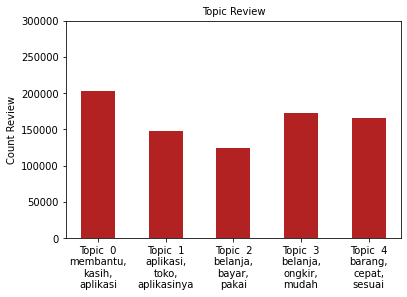

In [39]:
fig, ax1 = plt.subplots()

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', 
        data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x,pos: 'Topic  ' + str(x)+'\n'+ df_top3words.loc[df_top3words.topic_id==x,'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Topic Review', fontdict=dict(size=10))
ax1.set_ylabel('Count Review')
ax1.set_ylim(0,300000)

plt.show()